<a href="https://colab.research.google.com/github/madonnaojorin/Intro_to_MathBio/blob/main/Stochastic-SIR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction


* SIR model divides a population into Susceptible (if previously
had not been in contact with pathogen) Infected (currently contain
pathogen) and Removed (either recovered or died).


In [1]:
install.packages("deSolve")
library(deSolve)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [2]:
## A simple deterministic SIR model 
# S: the number susceptible
# I: the number infected and infectious
# R: the number recovered and immune
# Total population N = S + I + R

sir <- function(time, state, parameters) {
    with(as.list(c(state, parameters)), {
        dS <- -beta * S * I
        dI <- beta * S * I - gamma * I
        dR <- gamma * I
        return(list(c(dS, dI, dR)))
    })
}

In [3]:
## Initial conditions
init <- c(S = 99, I = 1, R = 0)

In [4]:
## Parameters
# beta:  The transmission rate (effective contact rate).
# gamma: The recovery rate (1/incubation period).
parameters <- c(beta = 0.01, gamma = 0.33)

In [5]:
## Time period
times <- seq(0, 70, by = 0.1)

In [6]:
## Solve the ODEs numerically
out <- as.data.frame(ode(y = init, times = times, func = sir, parms = parameters))
out$time <- NULL

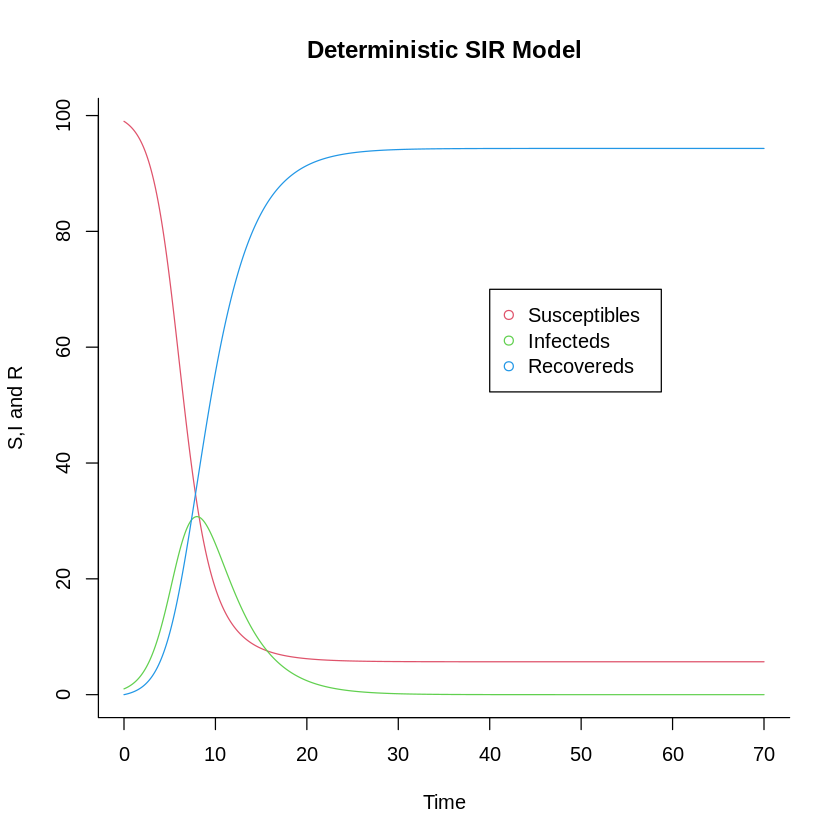

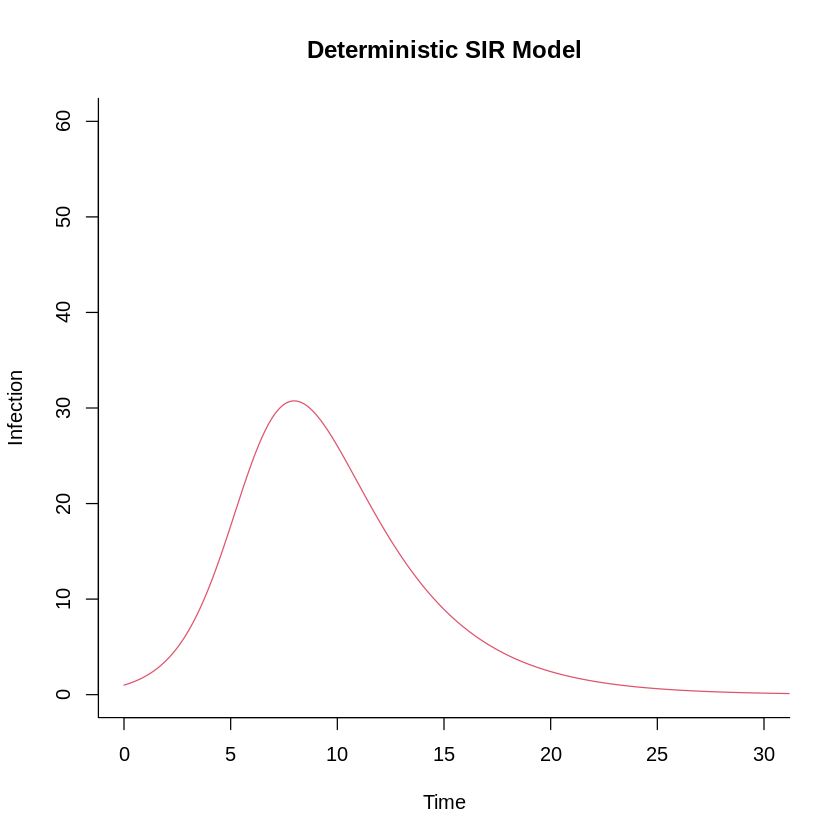

In [7]:
## Plot the reusults
matplot(times, out, type = "l", xlab = "Time", ylab = "S,I and R", main = "Deterministic SIR Model", lwd = 1, lty = 1, bty = "l", col = 2:4)
legend(40, 70, c("Susceptibles", "Infecteds", "Recovereds"), pch = 1, col = 2:4)

plot(times, out$I, type = "l", 
     xlab = "Time", ylab = "Infection", 
     main = "Deterministic SIR Model", 
     lwd = 1, lty = 1, bty = "l", col = 2:4,xlim = c(0, 30), ylim = c(0,60))

###Problem 1:
Calculate $\mathcal{R}_0$, when parameters are $\beta= 0.01$ and $\gamma=0.33$.



In [ ]:
(R0=parameters["beta"]/parameters["gamma"])

beta 
0.03030303

##Problem 2:
Calculate the final size. 

In [ ]:
(FinalSize = out[nrow(out),"R"])

[1] 94.32009

#Simulate a stochastic SIR model using Gillespie’s algorism 

While there are many ways of implementing stochastic framework such as MCMC or Reed-Frost model, here an event-driven method, Gillespie’s algorism is considered (Gillespie 1977).

Gillespie’s algorism is one of the event-driven methods, where randomness is included into transition time between each event. The integer number of individuals in each subpopulation defines the state of the system, which is changing discretely whenever an event occurs (transition from S compartment to I compartment or another one etc.). For the SIR model, it is required to consider the two events ($S\to I$ and $I\to R$) and changes in the numbers in each compartment (S, I and R) being resulted from each event .  Here $\mathcal{R}_0$ is mathematically equivalent to $\beta S(0)/\gamma$ similar with the above deterministic SIR model.


The following pseudo-code provides a slower, but often more intuitive, means of
modeling demographic stochasticity;
1. Label all possible events $E_1,\ldots,E_n$.
2. For each event determine the rate at which it occurs, $R_1,\ldots,R_n$.
3. For each event $m$ calculate the time until the next event is $\delta t_m =
−\frac{1}{R_m}\log(RAND_m)$.
4. Find the event, $p$, that happens first (has the smallest $\delta t$).
5. The time is now updated, $t \to \delta t_p$, and event $p$ is performed.
6. Return to Step 2.
  * With either of these popular implementations of stochasticity, the amount of
computer time needed to simulate a particular disease scenario increases
linearly with the population size.
  * Similarly, simulation of a large epidemic with many cases is slower than
simulating a disease close to its endemic level, as many more events occur in
the same time period.


In [9]:
gillespieSIR = function(beta, gamma, S0 = 99, I0 = 1, R0 = 0)
{
    times = S = I = R = c() # 1st step: initialise:
    k        = 1
    S[k]     = S0
    I[k]     = I0
    R[k]     = R0
    times[k] = 0

    ## Run model:
    keepgoing = TRUE
    while(keepgoing)
    {
        infrate = beta * S[k] * I[k]  # 2nd stap: calculate rates
        recrate = gamma * I[k]
        delta   = rexp(1, infrate + recrate) # 3rd step: simulate time
        times[k+1] = times[k] + delta       # 4th step: adjust time
        eventtype  = sample(c('infection','recovery'), 1, # 5th step
                            prob = c(infrate,recrate))

        if(eventtype == 'infection')
        {
            S[k+1] = S[k] - 1
            I[k+1] = I[k] + 1
            R[k+1] = R[k]
        }
        if(eventtype == 'recovery')
        {
            S[k+1] = S[k]
            I[k+1] = I[k] - 1
            R[k+1] = R[k] + 1
        }
        k = k+1
        if(I[k] == 0) keepgoing = FALSE # 6th step: decide when to stop
    }
    output = data.frame(times = times, S = S, I = I, R = R)
    return(output)
}


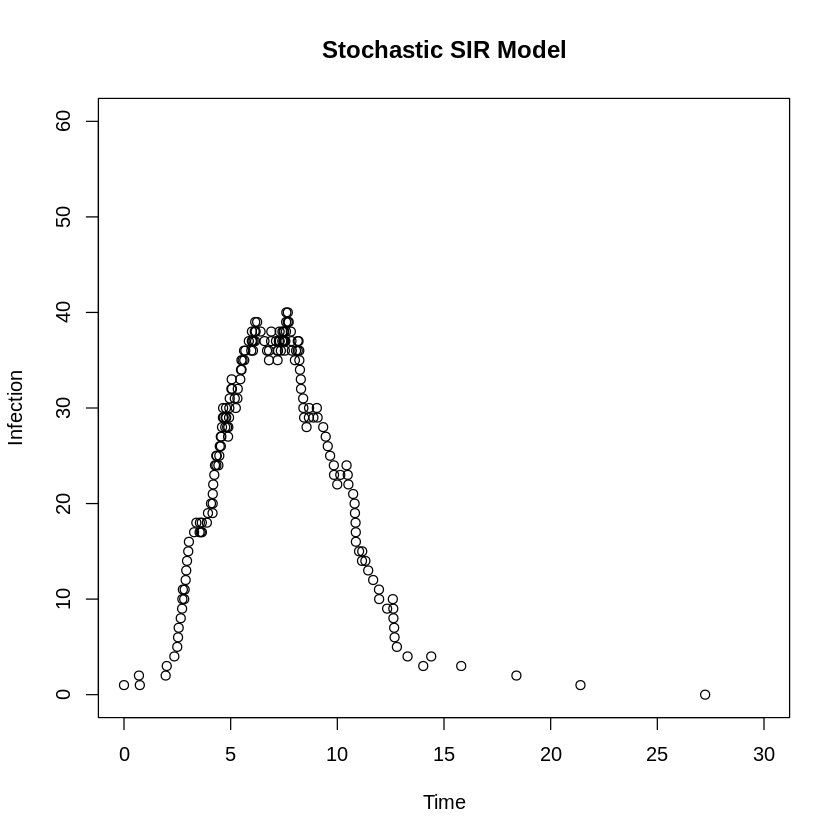

In [15]:
model1 = gillespieSIR(0.01, 0.33, 99, 1, 0)

plot(model1$times, model1$I, xlab = "Time", ylab = "Infection", main = "Stochastic SIR Model", xlim = c(0, 30), ylim = c(0,60))


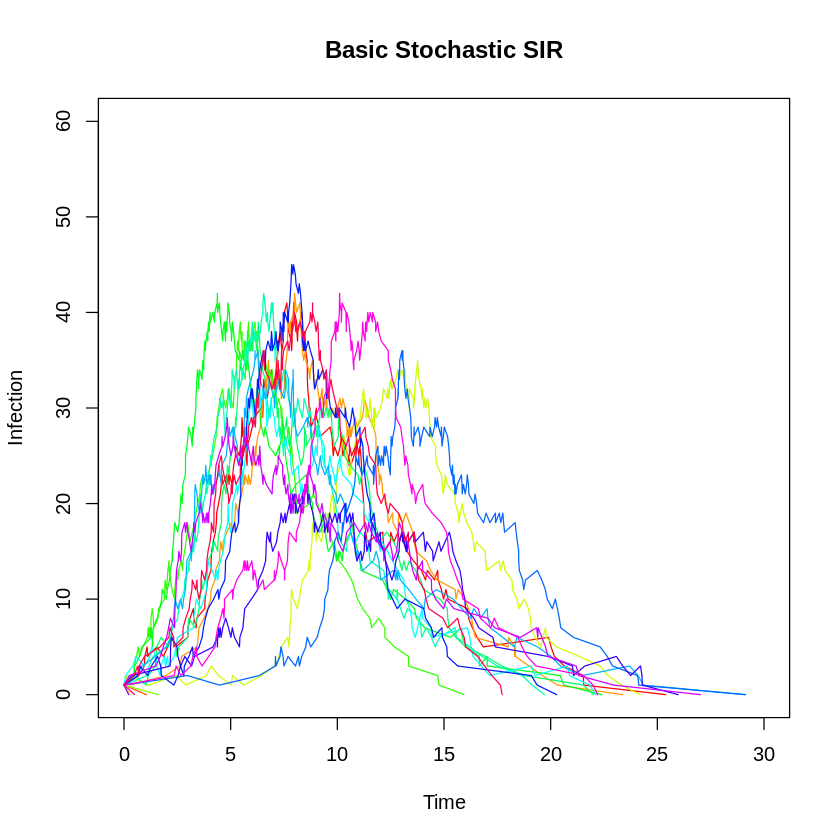

In [16]:
N <- 20
Result <- list(N)
for (i in 1:N) {
    ## (beta, gamma,S0, I0, R0) = (0.01, 0.33, 99, 1, 0)
    Result[[i]] <- gillespieSIR(0.01, 0.33, 99, 1, 0)
}
Col <- rainbow(N)
plot(Result[[1]]$time, Result[[1]]$I, type="l", col=Col[1], 
     xlab = "Time", ylab = "Infection", 
     main = "Basic Stochastic SIR", 
     xlim = c(0, 30), ylim = c(0,60))
for (i in 2:N) {
    lines(Result[[i]]$time, Result[[i]]$I, type = "l", col = Col[i])
}

2.5%   50% 97.5% 
    1    91    99

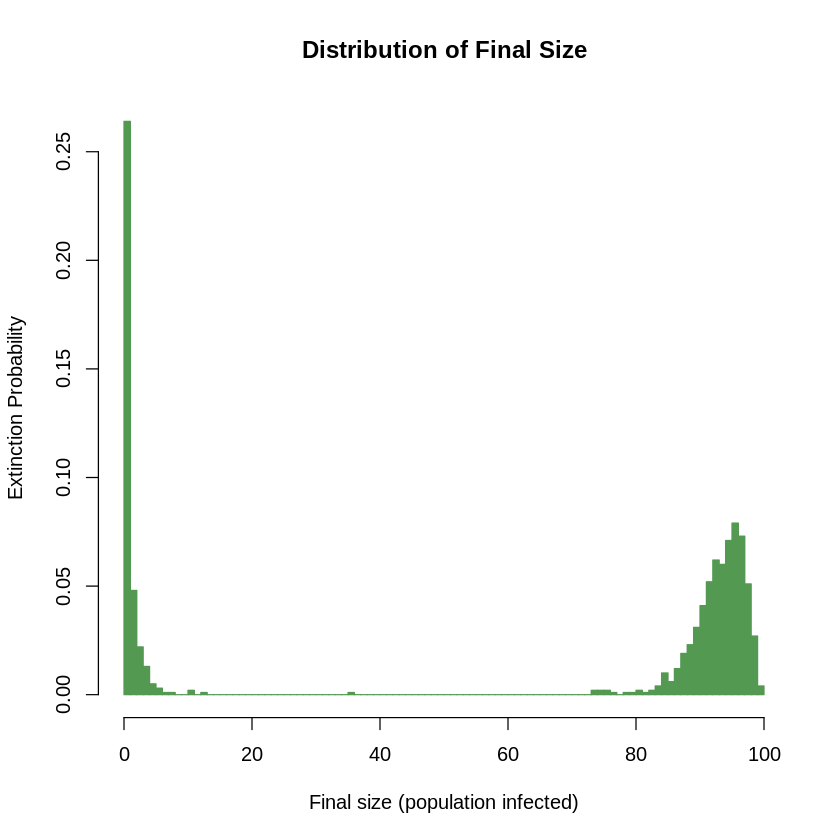

In [17]:
N <- 1000
Result <- list(N)
for (i in 1:N) {
    ## (beta, gamma,S0, I0, R0) = (0.01, 0.33, 99, 1, 0)
    Result[[i]] <- gillespieSIR(0.01, 0.33, 99, 1, 0)
}


finalsize2 <- numeric(N)
for (i in 1:N) {
    finalsize2[i] <- tail(Result[[i]],1)[["R"]]
}
hist(finalsize2, freq = FALSE, breaks = seq(0, 100, 1), col = "#539952", border = "#539952",
     xlab = "Final size (population infected)", ylab = "Extinction Probability",
     main = "Distribution of Final Size")

## Quartiles for the total population infected
quantile(finalsize2, p = c(0.025, 0.5, 0.975))

2.5%   50% 97.5% 
    1    92    99

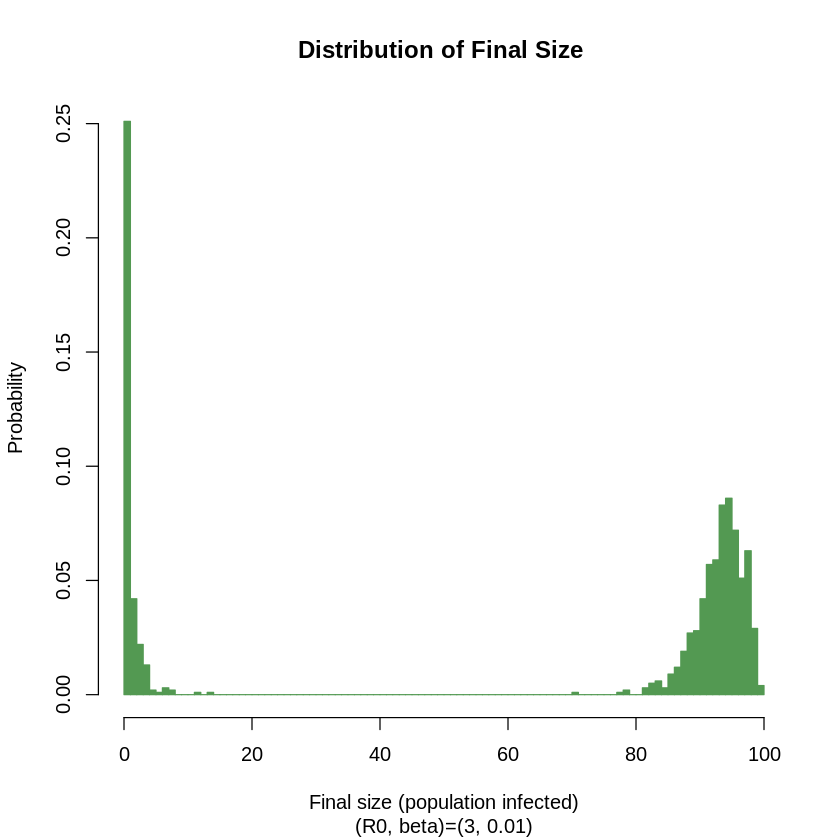

In [18]:
## beta = 0.01
N <- 1000
Result <- list(N)
for (i in 1:N) {
    ## (beta, gamma,S0, I0, R0) = (0.01, 0.33, 99, 1, 0)
  Result[[i]] <- gillespieSIR(0.01, 0.33, 99, 1, 0)
}

final1 <- numeric(N)
for (i in 1:N) {
    final1[i] <- tail(Result[[i]], 1)[["R"]]
}
hist(final1, freq = FALSE, breaks = seq(0, 100, 1), col = "#539952", border = "#539952", 
     xlab = "Final size (population infected)", 
     ylab = "Probability", 
     main = "Distribution of Final Size ",
     sub = "(R0, beta)=(3, 0.01)")
quantile(final1, p = c(0.025, 0.5, 0.975)) #final epidemic size of R0=3 beta=0.01

2.5%    50%  97.5% 
 1.000  1.000 41.025

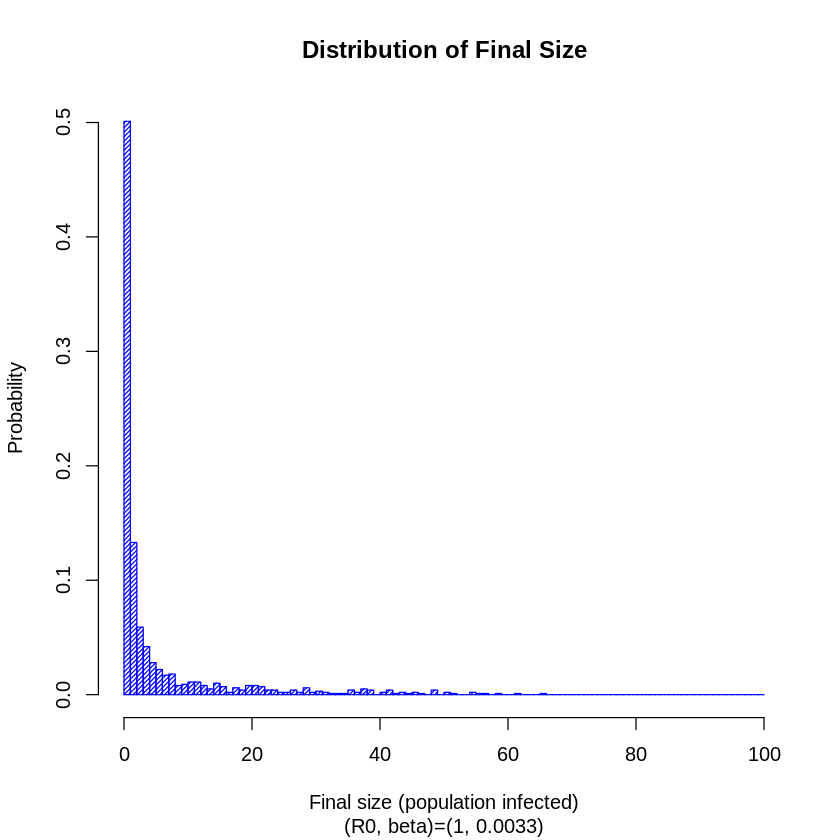

In [19]:
## beta = 0.0033
N <- 1000
Result <- list(N)
for (i in 1:N) {
    ## (beta, gamma,S0, I0, R0) = (0.0033, 0.33, 99, 1, 0)
    Result[[i]] <- gillespieSIR(0.0033, 0.33, 99, 1, 0)
}

final2 <- numeric(N)
for (i in 1:N) {
    final2[i] <- tail(Result[[i]], 1)[["R"]]
}
hist(final2, freq = FALSE, breaks = seq(0, 100, 1), density = 40, col = "blue", 
     xlab = "Final size (population infected)",
     ylab = "Probability", 
     main = "Distribution of Final Size",
     sub = "(R0, beta)=(1, 0.0033)")
quantile(final2,p=c(0.025,0.5,0.975)) #final epidemic size of R0=1 beta=0.0033

2.5%   50% 97.5% 
    1     1     4

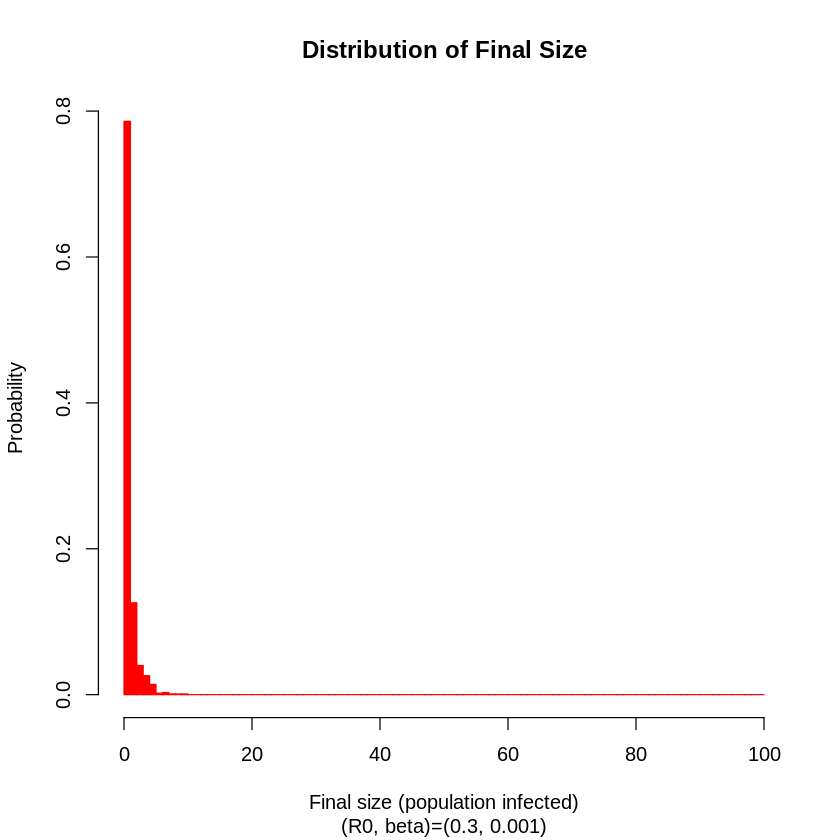

In [20]:
## beta = 0.001
N <- 1000
Result <- list(N)
for (i in 1:N) {
    ## (beta, gamma,S0, I0, R0) = (0.001, 0.33, 99, 1, 0)
    Result[[i]] <- gillespieSIR(0.001, 0.33, 99, 1, 0)
}

final3 <- numeric(N)
for (i in 1:N) {
    final3[i] <- tail(Result[[i]], 1)[["R"]]
}
hist(final3, freq = FALSE, breaks = seq(0, 100, 1), col = "red", border = "red", 
     xlab = "Final size (population infected)", 
     ylab = "Probability", 
     main = "Distribution of Final Size",
     sub = "(R0, beta)=(0.3, 0.001)")
quantile(final3, p = c(0.025, 0.5, 0.975)) #final epidemic size of R0=0.3 beta=0.001

2.5%   50% 97.5% 
    1    92    99

2.5%    50%  97.5% 
 1.000  1.000 41.025

2.5%   50% 97.5% 
    1     1     4

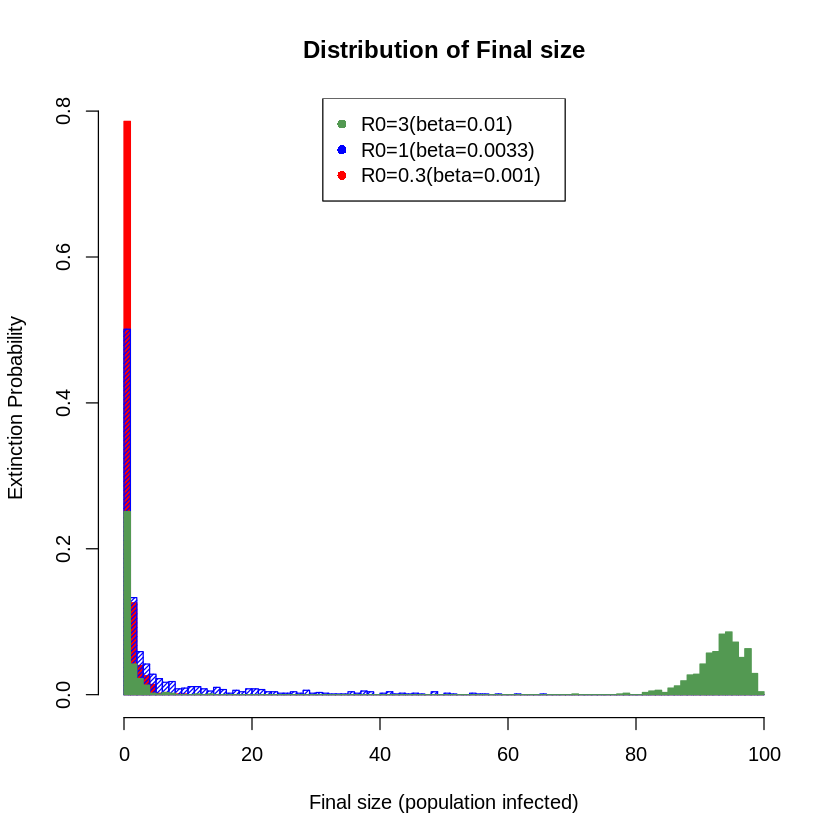

In [21]:
## Plot all cases
hist(final3, freq = FALSE, breaks = seq(0, 100, 1), col="red", border = "red",
     xlab = "Final size (population infected)", ylab = "Extinction Probability", main = "Distribution of Final size")
hist(final2, freq = FALSE, breaks = seq(0, 100, 1), density = 40, col = "blue", add = TRUE)
hist(final1, freq = FALSE, breaks = seq(0, 100, 1), col = "#539952", border = "#539952", add = TRUE)
legend("top", legend = c("R0=3(beta=0.01)", "R0=1(beta=0.0033)", "R0=0.3(beta=0.001)"), col = c("#539952", "blue", "red"), pch = 16)

## quartiles for the total population infected
quantile(final1, p = c(0.025, 0.5, 0.975)) # R0 = 3, beta = 0.01
quantile(final2, p = c(0.025, 0.5, 0.975)) # R0 = 1, beta = 0.0033
quantile(final3, p = c(0.025, 0.5, 0.975)) # R0 = 0.3, beta = 0.001

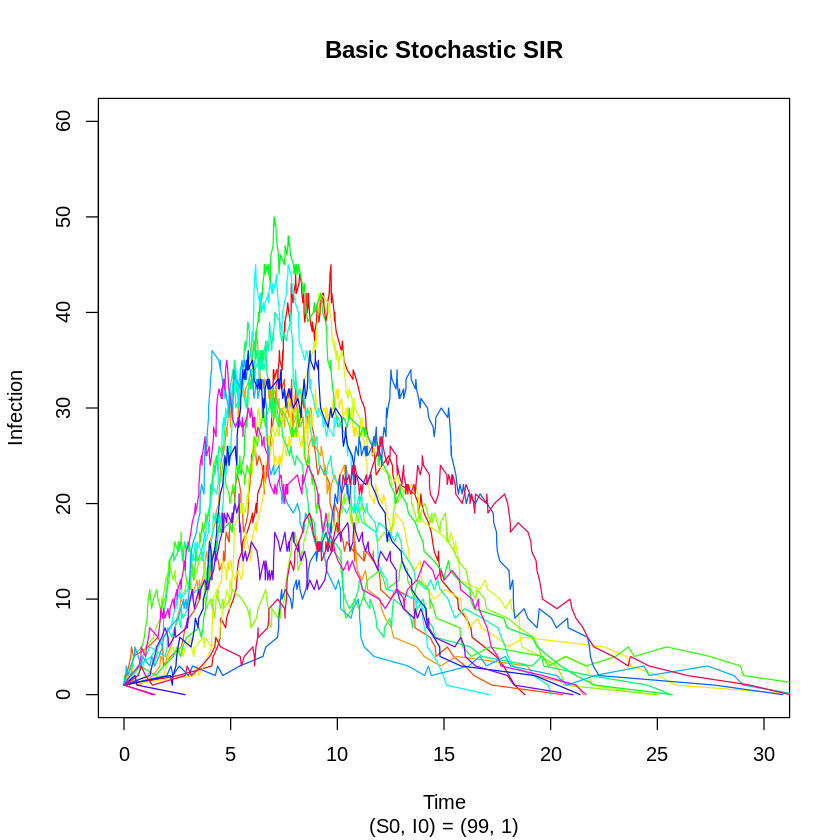

In [29]:
N <- 20
Result <- list(N)
for (i in 1:N) {
    ## Change the initial values and parameter
    ## (beta, gamma,S0, I0, R0) = (0.01, 0.33, 99, 1, 0)
    Result[[i]] <- gillespieSIR(0.01, 0.33, 99, 1, 0)
}
Col <- rainbow(N)
plot(Result[[1]]$time, Result[[1]]$I, type = "l", col = Col[1],
     xlab = "Time", ylab = "Infection",
     main = "Basic Stochastic SIR", 
     xlim = c(0, 30), ylim = c(0,60),
     sub = "(S0, I0) = (99, 1)")
for (i in 2:N) {
    lines(Result[[i]]$time, Result[[i]]$I, type = "l", col = Col[i])
}